In [57]:
!pip install numpy
!pip install torch
!pip install matplotlib

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [288]:
!wget https://raw.githubusercontent.com/PenTestical/german_names/master/2000_german_firstnames.txt

--2023-04-22 15:16:30--  https://raw.githubusercontent.com/PenTestical/german_names/master/2000_german_firstnames.txt
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 21220 (21K) [text/plain]
Wird in »2000_german_firstnames.txt« gespeichert.

2000_german_firstna 100%[===================>]  20,72K  --.-KB/s    in 0,001s  

2023-04-22 15:16:30 (14,5 MB/s) - »2000_german_firstnames.txt« gespeichert [21220/21220]



In [300]:
words = open("2000_german_firstnames.txt", encoding="ISO-8859-1").read().splitlines()
words = [x.lower() for x in words]

In [301]:
words[:4]

['abarhild', 'abbo', 'aberlin', 'abo']

In [302]:
chars = sorted(list(set(''.join(words))))

In [303]:
stoi = {s:i+1 for i,s in enumerate(chars)}

In [304]:
stoi['.'] = 0

In [305]:
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [351]:
block_size = 4

def build_dataset(words):
    X, Y = [], []
        
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([15025, 4]) torch.Size([15025])
torch.Size([1869, 4]) torch.Size([1869])
torch.Size([1839, 4]) torch.Size([1839])


In [383]:
n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(123456)

# 27, 10
C = torch.randn((vocab_size, n_embd), generator=g)

# 40, 100
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)

# 100, 
b1 = torch.randn(n_hidden, generator=g)

# 100, 30
W2 = torch.randn((n_hidden, vocab_size), generator=g) 

# 30,
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [386]:
epochs = 1000
steps = 10
lossi = []
epochloss = []

for e in range(epochs):
    # Training
    for i in range(steps):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)

        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)

        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb)

        for p in parameters:
            p.grad = None

        loss.backward()
        lossi.append(loss.item())

        # After about half the trainings batches we will cut the learning rate
        lr = 0.1 if len(lossi) <= ((epochs*steps)/2) else 0.01
            
        for p in parameters:
            p.data += -lr * p.grad
    
    #Evaluation
    with torch.no_grad():
        emb = C[Xdev]
        embcat = emb.view(emb.shape[0], -1)

        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ydev)
        
        epochloss.append(loss.item())
        print(f"Epoch {e} finished with loss: {loss}")

Epoch 0 finished with loss: 14.196252822875977
Epoch 1 finished with loss: 11.613037109375
Epoch 2 finished with loss: 9.890405654907227
Epoch 3 finished with loss: 9.019871711730957
Epoch 4 finished with loss: 8.310667991638184
Epoch 5 finished with loss: 7.939560413360596
Epoch 6 finished with loss: 7.564027786254883
Epoch 7 finished with loss: 7.192732334136963
Epoch 8 finished with loss: 7.00344705581665
Epoch 9 finished with loss: 6.835043430328369
Epoch 10 finished with loss: 6.647642612457275
Epoch 11 finished with loss: 6.489343643188477
Epoch 12 finished with loss: 6.25225830078125
Epoch 13 finished with loss: 6.161456108093262
Epoch 14 finished with loss: 5.9809465408325195
Epoch 15 finished with loss: 5.893694877624512
Epoch 16 finished with loss: 5.90270471572876
Epoch 17 finished with loss: 5.640957832336426
Epoch 18 finished with loss: 5.565992832183838
Epoch 19 finished with loss: 5.4189934730529785
Epoch 20 finished with loss: 5.341930866241455
Epoch 21 finished with lo

Epoch 235 finished with loss: 2.756221294403076
Epoch 236 finished with loss: 2.7402987480163574
Epoch 237 finished with loss: 2.7469210624694824
Epoch 238 finished with loss: 2.7531774044036865
Epoch 239 finished with loss: 2.7138402462005615
Epoch 240 finished with loss: 2.7110085487365723
Epoch 241 finished with loss: 2.718153715133667
Epoch 242 finished with loss: 2.7242934703826904
Epoch 243 finished with loss: 2.7333359718322754
Epoch 244 finished with loss: 2.7409989833831787
Epoch 245 finished with loss: 2.76496958732605
Epoch 246 finished with loss: 2.7299866676330566
Epoch 247 finished with loss: 2.6980597972869873
Epoch 248 finished with loss: 2.7161734104156494
Epoch 249 finished with loss: 2.746826648712158
Epoch 250 finished with loss: 2.7633354663848877
Epoch 251 finished with loss: 2.7286248207092285
Epoch 252 finished with loss: 2.71700382232666
Epoch 253 finished with loss: 2.7377431392669678
Epoch 254 finished with loss: 2.698657751083374
Epoch 255 finished with loss

Epoch 477 finished with loss: 2.372053623199463
Epoch 478 finished with loss: 2.3836028575897217
Epoch 479 finished with loss: 2.395611047744751
Epoch 480 finished with loss: 2.3753440380096436
Epoch 481 finished with loss: 2.3904340267181396
Epoch 482 finished with loss: 2.375854730606079
Epoch 483 finished with loss: 2.4013261795043945
Epoch 484 finished with loss: 2.424368143081665
Epoch 485 finished with loss: 2.395753860473633
Epoch 486 finished with loss: 2.399512767791748
Epoch 487 finished with loss: 2.3667969703674316
Epoch 488 finished with loss: 2.3986830711364746
Epoch 489 finished with loss: 2.4254796504974365
Epoch 490 finished with loss: 2.368865966796875
Epoch 491 finished with loss: 2.3734018802642822
Epoch 492 finished with loss: 2.3675763607025146
Epoch 493 finished with loss: 2.377995014190674
Epoch 494 finished with loss: 2.3992362022399902
Epoch 495 finished with loss: 2.3869524002075195
Epoch 496 finished with loss: 2.430478096008301
Epoch 497 finished with loss:

Epoch 713 finished with loss: 2.2798726558685303
Epoch 714 finished with loss: 2.282101631164551
Epoch 715 finished with loss: 2.2845005989074707
Epoch 716 finished with loss: 2.2821178436279297
Epoch 717 finished with loss: 2.2840006351470947
Epoch 718 finished with loss: 2.2786853313446045
Epoch 719 finished with loss: 2.279472589492798
Epoch 720 finished with loss: 2.2793006896972656
Epoch 721 finished with loss: 2.279787063598633
Epoch 722 finished with loss: 2.2787442207336426
Epoch 723 finished with loss: 2.2778193950653076
Epoch 724 finished with loss: 2.2788784503936768
Epoch 725 finished with loss: 2.281257390975952
Epoch 726 finished with loss: 2.281961441040039
Epoch 727 finished with loss: 2.2814719676971436
Epoch 728 finished with loss: 2.280818462371826
Epoch 729 finished with loss: 2.281228542327881
Epoch 730 finished with loss: 2.2805562019348145
Epoch 731 finished with loss: 2.2787482738494873
Epoch 732 finished with loss: 2.2767488956451416
Epoch 733 finished with los

Epoch 941 finished with loss: 2.2601683139801025
Epoch 942 finished with loss: 2.2591135501861572
Epoch 943 finished with loss: 2.25946044921875
Epoch 944 finished with loss: 2.2591171264648438
Epoch 945 finished with loss: 2.259255886077881
Epoch 946 finished with loss: 2.2587790489196777
Epoch 947 finished with loss: 2.256258010864258
Epoch 948 finished with loss: 2.2582037448883057
Epoch 949 finished with loss: 2.259290933609009
Epoch 950 finished with loss: 2.262643814086914
Epoch 951 finished with loss: 2.2600135803222656
Epoch 952 finished with loss: 2.26047420501709
Epoch 953 finished with loss: 2.259593963623047
Epoch 954 finished with loss: 2.257599353790283
Epoch 955 finished with loss: 2.2586889266967773
Epoch 956 finished with loss: 2.256862163543701
Epoch 957 finished with loss: 2.258094072341919
Epoch 958 finished with loss: 2.2562947273254395
Epoch 959 finished with loss: 2.255556106567383
Epoch 960 finished with loss: 2.257411479949951
Epoch 961 finished with loss: 2.25

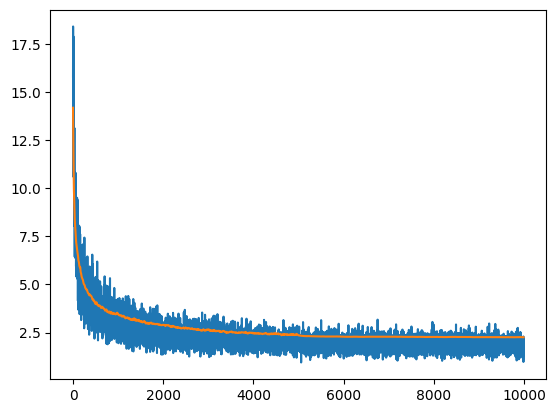

In [387]:
# Plot

plt.plot(lossi, )
plt.plot(np.arange(0, 10000, 10), epochloss)

In [371]:
with torch.no_grad():
    emb = C[Xte]
    embcat = emb.view(emb.shape[0], -1)

    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)

    print(f"Test Loss: {loss.item()}")

Test Loss: 2.0407168865203857


In [380]:
def generate_name():
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        
        
        with torch.no_grad():
            hpreact = embcat @ W1 + b1
            h = torch.tanh(hpreact)

            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
        
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()

            context = context[1:] + [ix]
                
            if ix == 0:
                break
            else:
                out.append(ix)
        
    print(''.join(itos[i] for i in out))

In [381]:
for i in range(10):
    generate_name()

gunde
reid
wille
grutfhindis
heberdo
elmutfreim
aste
henbuid
fosrundeerund
lanke
